In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dataset=pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv", header=None)

In [3]:
dataset

,0,1,2,3,4,5,6,7,8
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [4]:
dataset_train=dataset.iloc[0:600]
dataset_train

,0,1,2,3,4,5,6,7,8
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
595,0,188,82,14,185,32.0,0.682,22,1
596,0,67,76,0,0,45.3,0.194,46,0
597,1,89,24,19,25,27.8,0.559,21,0
598,1,173,74,0,0,36.8,0.088,38,1


In [5]:
dataset_val=dataset.iloc[600:768]
print(dataset_val)

      0    1   2   3    4     5      6   7  8
600   1  108  88  19    0  27.1  0.400  24  0
601   6   96   0   0    0  23.7  0.190  28  0
602   1  124  74  36    0  27.8  0.100  30  0
603   7  150  78  29  126  35.2  0.692  54  1
604   4  183   0   0    0  28.4  0.212  36  1
..   ..  ...  ..  ..  ...   ...    ...  .. ..
763  10  101  76  48  180  32.9  0.171  63  0
764   2  122  70  27    0  36.8  0.340  27  0
765   5  121  72  23  112  26.2  0.245  30  0
766   1  126  60   0    0  30.1  0.349  47  1
767   1   93  70  31    0  30.4  0.315  23  0

[168 rows x 9 columns]


In [6]:
X=dataset_train[[0,1,2,3,4,5,6,7]].values
y=dataset_train[8].values
X_val=dataset_val[[0,1,2,3,4,5,6,7]].values
y_val=dataset_val[8].values

In [43]:
class LogisticRegression:
    def __init__(self,lr=0.001,batch_size=10000,epochs=1000,l2_lambda=0.1,patience=5,delta=0.05):
        self.lr=lr
        self.batch_size=batch_size
        self.l2_lambda=l2_lambda
        self.epochs=epochs
        self.patience=patience
        self.delta=delta
        self.weight=None
        self.bias=None
        self.mean=None
        self.std=None
        

        self.loss_history=[]
        self.val_loss=[]

        self.best_weight=None
        self.best_bias=None
        self.best_loss=None
        self.wait=0

        self.early_stop=False
    def sigmoid(self, z):
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))  # Correct formula

    def train(self,X,y,X_val,Y_val):
        n_sample,n_feature=X.shape

        np.random.seed(42)
        self.weight=np.random.randn(n_feature)
        self.bias=np.random.randn()

        X=(X-X.mean())/(X.std() +1e-8)
        
        X_val=(X_val-X_val.mean())/(X_val.std() +1e-8)
        for i in range(self.epochs):
            indices=np.random.permutation(n_sample)
            X_shuffle=X[indices]
            y_shuffle=y[indices]

            for d in range(0,n_sample,self.batch_size):
                X_batch=X_shuffle[d:d+self.batch_size]
                y_batch=y_shuffle[d:d+self.batch_size]
                batch_size_used=len(X_batch)

                z=np.dot(X_batch,self.weight)+ self.bias
                y_predicted=self.sigmoid(z)
                error=y_predicted-y_batch

                gradient_weight=(1/batch_size_used)*np.dot(X_batch.T,error)
                gradient_bias=(1/batch_size_used)*np.sum(error)
                gradient_weight+=2*self.l2_lambda*self.weight

                self.weight -=gradient_weight*self.lr
                self.bias  -=gradient_bias*self.lr

                loss=-np.mean(y_batch * np.log(y_predicted + 1e-15)+(1-y_batch)*np.log(1-y_predicted +1e-15))
                
                penalty=self.l2_lambda*np.sum(self.weight**2)
                loss+=penalty

                self.loss_history.append(loss)

                z2=np.dot(X_val,self.weight)+self.bias
                y_predi_val=self.sigmoid(z2)
                loss_val= -np.mean(y_val * np.log(y_predi_val) + (1 - y_val)* np.log( 1- y_predi_val))
                
                self.val_loss.append(loss_val)
            if self.best_loss is None or loss_val < self.best_loss - self.delta:
                self.bestloss=loss_val
                self.best_weight=np.copy(self.weight)
                self.best_bias=np.copy(self.bias)
                self.wait=0
            else:
                self.wait+=1
                if self.wait>=self.patience:
                    print(f'the early stop is at {i}')
                    self.early_stop=True
                    break
        if self.best_weight is not None:
            self.weight=self.best_weight
            self.bias=self.best_bias
    def predict(self, X):
        X_norm = (X - self.mean) / (self.std + 1e-8)
        z = np.dot(X_norm, self.weight) + self.bias
        y_pred = self._sigmoid(z)
        return y_pred        
                

In [44]:
model=LogisticRegression()

In [45]:
model.train(X,y,X_val,y_val)

In [46]:
model.loss_history

[np.float64(1.669359841779957),
 np.float64(1.6683031277209412),
 np.float64(1.6672472295042633),
 np.float64(1.6661921473301047),
 np.float64(1.6651378813985493),
 np.float64(1.6640844319095804),
 np.float64(1.6630317990630767),
 np.float64(1.6619799830588113),
 np.float64(1.6609289840964467),
 np.float64(1.6598788023755322),
 np.float64(1.658829438095502),
 np.float64(1.65778089145567),
 np.float64(1.6567331626552293),
 np.float64(1.6556862518932471),
 np.float64(1.6546401593686615),
 np.float64(1.6535948852802806),
 np.float64(1.652550429826777),
 np.float64(1.6515067932066856),
 np.float64(1.650463975618401),
 np.float64(1.6494219772601724),
 np.float64(1.6483807983301033),
 np.float64(1.647340439026146),
 np.float64(1.646300899546099),
 np.float64(1.6452621800876048),
 np.float64(1.6442242808481442),
 np.float64(1.6431872020250373),
 np.float64(1.6421509438154351),
 np.float64(1.6411155064163199),
 np.float64(1.6400808900245012),
 np.float64(1.6390470948366116),
 np.float64(1.6380

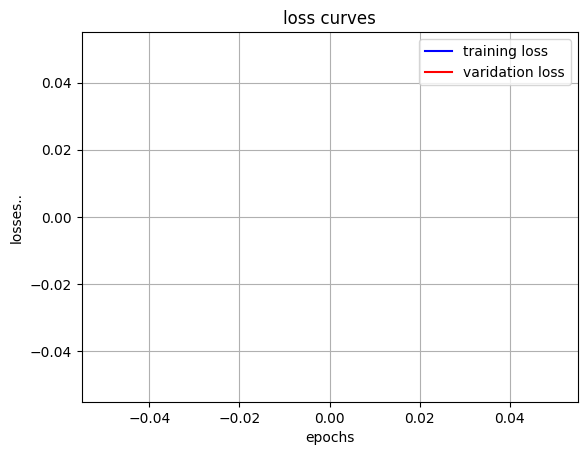

In [25]:
plt.plot(model.loss_history,color='blue',label='training loss')
plt.plot(model.val_loss,color='red',label='varidation loss')
plt.xlabel('epochs')
plt.ylabel('losses..')
plt.title('loss curves')
plt.grid(True)
plt.legend()
plt.show()